# Data Generation

This notebook generates the data for the VRP instances.

In [ ]:
SOLVE = False

In [9]:
import pickle
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np

np.random.seed(42)

In [10]:
INSTANCE_PATH = Path("data")
RESULTS_PATH = Path("results")

if not INSTANCE_PATH.exists():
    INSTANCE_PATH.mkdir()

In [16]:
def generate_single_instance(num_nodes, demand_low=1, demand_high=10):
    depot_location = np.array([[0.5, 0.5]])
    depot_demand = np.array([[0]])

    locations = np.concatenate((depot_location, np.random.rand(num_nodes, 2)), axis=0)
    demands = np.concatenate((depot_demand, np.random.randint(demand_low, demand_high, (num_nodes, 1))), axis=0)

    return np.concatenate((locations, demands), axis=1)

In [17]:
generate_single_instance(10)

array([[0.5       , 0.5       , 0.        ],
       [0.37454012, 0.95071431, 3.        ],
       [0.73199394, 0.59865848, 7.        ],
       [0.15601864, 0.15599452, 4.        ],
       [0.05808361, 0.86617615, 9.        ],
       [0.60111501, 0.70807258, 3.        ],
       [0.02058449, 0.96990985, 5.        ],
       [0.83244264, 0.21233911, 3.        ],
       [0.18182497, 0.18340451, 7.        ],
       [0.30424224, 0.52475643, 5.        ],
       [0.43194502, 0.29122914, 9.        ]])

In [18]:
def generate_instances(num_instances, num_nodes=10):
    all_instances = []
    for i in range(num_instances):
        all_instances.append(generate_single_instance(num_nodes))
    return np.array(all_instances)


In [19]:
instances = generate_instances(2000, 10)

In [20]:
with open(INSTANCE_PATH / "instances.pkl", "wb") as f:
    pickle.dump(instances, f)

## Visualizing the instances

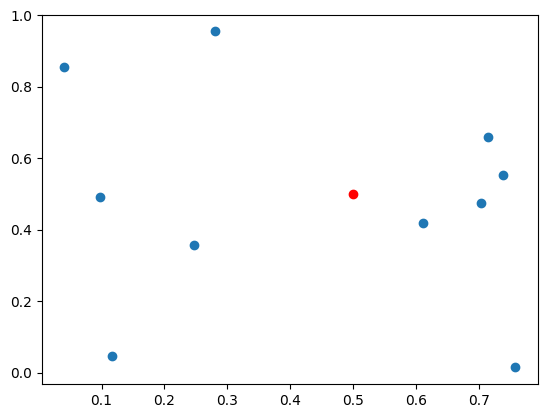

In [24]:
idx = 10

plt.scatter(instances[idx, 1:, 0], instances[idx, 1:, 1])
plt.scatter(instances[idx, 0, 0], instances[idx, 0, 1], c="r")

# Solving the instances

We solve the instances with the [Google OR-Tools](https://developers.google.com/optimization/routing/vrp) and save the solutions. To make use of multiprocessing we can't run the code from the notebook. Instead we run the code from the command line.

In [9]:
if SOLVE:
    !python solver.py --filename {INSTANCE_PATH/ "instances.pkl"} --num_vehicles 4 --vehicle_capacity 25

Starting processing with 8 workers
100%|███████████████████████████████████████| 2000/2000 [10:53<00:00,  3.06it/s]
Done in 882.0996460914612 seconds


# Mergin data

Merging the instances and solutions

In [25]:
with open(RESULTS_PATH / "vrp_4_25.pkl", 'rb') as f:
    results = pickle.load(f)
    
with open(INSTANCE_PATH / 'instances.pkl', 'rb') as f:
    instances = pickle.load(f)

In [26]:
results[:3]

[{'classifications': array([-1,  0,  1,  2,  1,  0,  0,  0,  2,  2,  1]),
  'routes': {0: [5, 6, 1, 7], 1: [2, 10, 4], 2: [9, 3, 8], 3: []},
  'total_distance': 3.9,
  'instance': 0},
 {'classifications': array([-1,  0,  2,  2,  1,  2,  1,  1,  2,  2,  2]),
  'routes': {0: [1], 1: [7, 4, 6], 2: [10, 3, 2, 5, 8, 9], 3: []},
  'total_distance': 4.266,
  'instance': 1},
 {'classifications': array([-1,  2,  1,  1,  0,  2,  2,  2,  1,  1,  2]),
  'routes': {0: [4], 1: [8, 3, 2, 9], 2: [10, 5, 6, 1, 7], 3: []},
  'total_distance': 3.474,
  'instance': 2}]

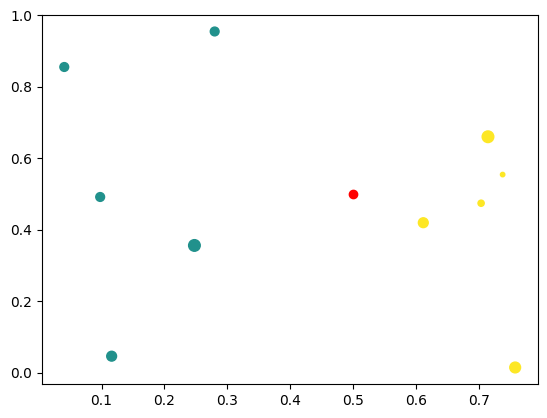

In [27]:
plt.scatter(instances[idx, :, 0], instances[idx, :, 1], c=results[idx]['classifications'], s=10 * instances[idx, :, 2])
plt.scatter(instances[idx, 0, 0], instances[idx, 0, 1], c="r")

In [35]:
# Ensure the order of the instances are correct
assert np.all(np.arange(len(results)) == np.fromiter(map(lambda x: x['instance'], results), dtype=int))

errors = [s['total_distance'] == 0 for s in results]

assert np.sum(errors) == 0

In [41]:
dataset = [(x, y['classifications']) for (x, y) in zip(instances, results)]
dataset[0]

(array([[0.5       , 0.5       , 0.        ],
        [0.06505159, 0.94888554, 2.        ],
        [0.96563203, 0.80839735, 4.        ],
        [0.30461377, 0.09767211, 8.        ],
        [0.68423303, 0.44015249, 7.        ],
        [0.12203823, 0.49517691, 9.        ],
        [0.03438852, 0.9093204 , 8.        ],
        [0.25877998, 0.66252228, 5.        ],
        [0.31171108, 0.52006802, 2.        ],
        [0.54671028, 0.18485446, 5.        ],
        [0.96958463, 0.77513282, 8.        ]]),
 array([-1,  0,  1,  2,  1,  0,  0,  0,  2,  2,  1]))

In [42]:
with open(INSTANCE_PATH / 'dataset.pkl', 'wb') as f:
    pickle.dump(dataset, f)